# Adversarial Examples for Vanilla Neural Networks

Adversarial examples are inputs to a neural network that are designed to "trick" the neural network. For example, [here](https://blog.openai.com/robust-adversarial-inputs/) is a cool project that an intern at OpenAI did on adversarial examples. They managed "convince" an image recognition neural network that a picture of a cat was a desktop computer. Adversarial examples are incredibly important when it comes to the security of neural network models and is currently a very active field of research (for example, a [paper](https://arxiv.org/pdf/1611.02770.pdf) from Berkeley's own Dawn Song).

Here is an example of an image of a panda with added noise that a neural network thinks with 99.3% confidence is a gibbon:

![](https://blog.openai.com/content/images/2017/02/adversarial_img_1.png)

This notebook does something similar. It takes a neural network trained to recognize handwritten digits (MNIST) and implements code to generate images that "trick" the neural network. For example, we'll generate images that look like a '2' but the network will think is a '6'. The digits that the network was trained on look something like this:

![](http://neuralnetworksanddeeplearning.com/images/digits.png)

(The neural network was implemented by Michael Nielsen for his [Neural Networks and Deep Learning](http://neuralnetworksanddeeplearning.com/) book. We encourage you to read it!)

First, let's import all the dependencies we'll need:

In [1]:
%matplotlib inline
# --*-- coding: utf-8 --*--
import network.network as Network
import network.mnist_loader as mnist_loader
import pickle
import matplotlib.pyplot as plt
import numpy as np
import gzip


Next, we'll unpickle the pre-trained neural network and use a helpful helper function to load up the MNIST data. The network has only one hidden layer of 30 units, 784 input units (MNIST images are $ 28 \times 28 = 784 $ pixels large), and 10 output units. All the activations are sigmoidal:

In [2]:
with open('network/trained_network.pkl', 'rb') as f:
#     u = pickle._Unpickler(f)
#     u.encoding = 'latin1'
#     net = u.load()
    net = pickle.load(f, encoding='latin1')

    
training_data, validation_data, test_data = mnist_loader.load_data_wrapper()

In [3]:
print(test_data[0])

(array([[0.        ],
       [0.        ],
       [0.        ],
       [0.        ],
       [0.        ],
       [0.        ],
       [0.        ],
       [0.        ],
       [0.        ],
       [0.        ],
       [0.        ],
       [0.        ],
       [0.        ],
       [0.        ],
       [0.        ],
       [0.        ],
       [0.        ],
       [0.        ],
       [0.        ],
       [0.        ],
       [0.        ],
       [0.        ],
       [0.        ],
       [0.        ],
       [0.        ],
       [0.        ],
       [0.        ],
       [0.        ],
       [0.        ],
       [0.        ],
       [0.        ],
       [0.        ],
       [0.        ],
       [0.        ],
       [0.        ],
       [0.        ],
       [0.        ],
       [0.        ],
       [0.        ],
       [0.        ],
       [0.        ],
       [0.        ],
       [0.        ],
       [0.        ],
       [0.        ],
       [0.        ],
       [0.        ],
       [0.  

The neural network is pretrained, so it should already be set up to predict characters. Run `predict(n)` to evaluate the $ n^{th} $ digit in the test set using the network. You should see that even this relatively simple network works really well (~97% accuracy). The output of the network is a one-hot vector indicating the network's predictions:

Network output: 
[[0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [1.]
 [0.]]

Network prediction: 8

Actual image: 


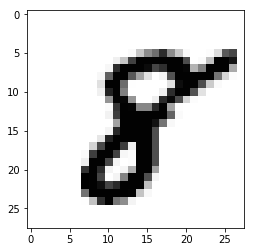

In [7]:
def predict(n):
    # Get the data from the test set
    x = test_data[n][0]

    # Print the prediction of the network

    print('Network output: \n' + str(np.round(net.feedforward(x), 2)) + '\n')
    print('Network prediction: ' + str(np.argmax(net.feedforward(x))) + '\n')
    print('Actual image: ')
    
    # Draw the image
    plt.imshow(x.reshape((28,28)),cmap='Greys')
#     plt.imshow(x.reshape((28,28)), cmap='Greys')

# Replace the argument with any number between 0 and 9999
predict(8384)

To actually generate adversarial examples we solve a minimization problem. We do this by setting a "goal" label called $ \vec y_{goal} $ (for instance, if we wanted the network to think the adversarial image is an 8, then we would choose $ \vec y_{goal} $ to be a one-hot vector with the eighth entry being 1). Now we define a cost function:

$$ C = \frac{1}{2} \|\vec y_{goal} - \hat y(\vec x)\|^2_2 $$

where $ \| \cdot \|^2_2 $ is the squared Euclidean norm and $ \hat y $ is the network's output. It is a function of $ \vec x $, the input image to the network, so we write $ \hat y(\vec x) $. Our goal is to find an $ \vec x $ such that $ C $ is minimized. Hopefully this makes sense, because if we find an image $ \vec x $ that minimizes $ C $ then that means the output of the network when given $ \vec x $ is close to our desired output, $ \vec y_{goal} $. So in full mathy language, our optimization problem is:

$$ \arg \min_{\vec x} C(\vec x) $$

that is, find the $ \vec x $ that minimizes the cost $ C $.

To actually do this we can do gradient descent on $ C $. Start with an initially random vector $ \vec x $ and take steps (changing $ \vec x $) gradually in the direction opposite of the gradient $ \nabla_x C $. To actually get these derivatives we can perform backpropagation on the network. In contrast to training a network, where we perform gradient descent on the weights and biases, when we create adversarial examples we hold the weights and biases constant (because we don't want to change the network!), and change the inputs to our network.

First a couple helper functions to evaluate the non-linearity and it's derivative:

In [14]:
def sigmoid(z):
    """The sigmoid function."""
    return 1.0/(1.0+np.exp(-z))
                                                                                                                                                                                
def sigmoid_prime(z):
    """Derivative of the sigmoid function."""
    return sigmoid(z)*(1-sigmoid(z))

Also, a function to gradient the derivative of the cost function, $ \nabla_x C $ with respect to the input $ \vec x $, with a goal label of $ \vec y_{goal} $. (Don't worry too much about the implementation, just know it calcualtes derivatives).

In [34]:
def input_derivative(net, x, y):
    """ Calculate derivatives wrt the inputs"""
    nabla_b = [np.zeros(b.shape) for b in net.biases]
    nabla_w = [np.zeros(w.shape) for w in net.weights]
    
    # feedforward
    activation = x
    activations = [x] # list to store all the activations, layer by layer
    zs = [] # list to store all the z vectors, layer by layer
    for b, w in zip(net.biases, net.weights):
        z = np.dot(w, activation)+b
        zs.append(z)
        activation = sigmoid(z)
        activations.append(activation)
        
    # backward pass
    delta = net.cost_derivative(activations[-1], y) * \
        sigmoid_prime(zs[-1])
    nabla_b[-1] = delta
    nabla_w[-1] = np.dot(delta, activations[-2].transpose())

    for l in range(2, net.num_layers):
        z = zs[-l]
        sp = sigmoid_prime(z)
        delta = np.dot(net.weights[-l+1].transpose(), delta) * sp
        nabla_b[-l] = delta
        nabla_w[-l] = np.dot(delta, activations[-l-1].transpose())
        
    # Return derivatives WRT to input
    return net.weights[0].T.dot(delta)

The actual function that generates adversarial examples and a wrapper function:

In [35]:
def adversarial(net, n, steps, eta):
    """
    net : network object
        neural network instance to use
    n : integer
        our goal label (just an int, the function transforms it into a one-hot vector)
    steps : integer
        number of steps for gradient descent
    eta : float
        step size for gradient descent
    """
    # Set the goal output
    goal = np.zeros((10, 1))
    goal[n] = 1

    # Create a random image to initialize gradient descent with
    x = np.random.normal(.5, .3, (784, 1))

    # Gradient descent on the input
    for i in range(steps):
        # Calculate the derivative
        d = input_derivative(net,x,goal)
        
        # The GD update on x
        x -= eta * d
        
    return x

# Wrapper function
def generate(n):
    """
    n : integer
        goal label (not a one hot vector)
    """
    a = adversarial(net, n, 1000, 1)
    x = np.round(net.feedforward(a), 2)
    
    print('Network Output: \n' + str(x) + '\n')
    
    print('Network Prediction: ' + str(np.argmax(x)) + '\n')
    
    print('Adversarial Example: ')
    plt.imshow(a.reshape(28,28), cmap='Greys')

Now let's generate some adversarial examples! Use the function provided to mess around with the neural network. (For some inputs gradient descent doesn't always converge; 0 and 5 seem to work pretty well though. I suspect convergence is very highly dependent on our choice of random initial $ \vec x $. We'll see later in the notebook if we force the adversarial example to "look like" a handwritten digit, convergence is much more likely. In a sense we will be adding regularization to our generation process).

Network Output: 
[[0.  ]
 [0.  ]
 [0.  ]
 [0.  ]
 [0.  ]
 [0.  ]
 [0.  ]
 [0.98]
 [0.  ]
 [0.  ]]

Network Prediction: 7

Adversarial Example: 


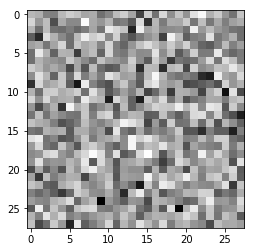

In [59]:
ｇｅｎｅｒａｔｅ(7)

Sweet! We've just managed to create an image that looks utterly meaningless to a human, but the neural network thinks is a '5' with very high certainty. We can actually take this a bit further. Let's generate an image that looks like one number, but the neural network is certain is another. To do this we will modify our cost function a bit. Instead of just optimizing the input image, $ \vec x $, to get a desired output label, we'll also optimize the input to look like a certain image, $ \vec x_{target} $, at the same time. Our new cost function will be

$$ C = \|\vec y_{goal} - y_{hat}(\vec x)\|^2_2 + \lambda \|\vec x - \vec x_{target}\|^2_2 $$

The added term tells us the distance from our $ \vec x $ and some $ \vec x_{target} $ (which is the image we want our adversarial example to look like). Because we want to minimize $ C $, we also want to minimize the distance between our adversarial example and this image. The $ \lambda $ is hyperparameter that we can tune; it determines which is more important: optimizing for the desired output or optimizing for an image that looks like $ \vec x_{target} $.

If you are familiar with ridge regularization, the above cost function might look suspiciously like the ridge regression cost function. In fact, we can view this generation method as giving our model a prior, centered on our target image.

Here is a function that implements optimizing the modified cost function, called `sneaky_adversarial` (because it is very sneaky). Note that the only difference between this function and `adversarial` is an additional term on the gradient descent update for the regularization term:

In [60]:
def sneaky_adversarial(net, n, x_target, steps, eta, lam=.05):
    """
    net : network object
        neural network instance to use
    n : integer
        our goal label (just an int, the function transforms it into a one-hot vector)
    x_target : numpy vector
        our goal image for the adversarial example
    steps : integer
        number of steps for gradient descent
    eta : float
        step size for gradient descent
    lam : float
        lambda, our regularization parameter. Default is .05
    """
    
    # Set the goal output
    goal = np.zeros((10, 1))
    goal[n] = 1

    # Create a random image to initialize gradient descent with
    x = np.random.normal(.5, .3, (784, 1))

    # Gradient descent on the input
    for i in range(steps):
        # Calculate the derivative
        d = input_derivative(net,x,goal)
        
        # The GD update on x, with an added penalty to the cost function
        # ONLY CHANGE IS RIGHT HERE!!!
        x -= eta * (d + lam * (x - x_target))

    return x

# Wrapper function
def sneaky_generate(n, m):
    """
    n: int 0-9, the target number to match
    m: index of example image to use (from the test set)
    """
    
    # Find random instance of m in test set
    idx = np.random.randint(0,8000)
    while test_data[idx][1] != m:
        idx += 1
    
    # Hardcode the parameters for the wrapper function
    a = sneaky_adversarial(net, n, test_data[idx][0], 100, 1)
    x = np.round(net.feedforward(a), 2)
    
    print('\nWhat we want our adversarial example to look like: ')
    plt.imshow(test_data[idx][0].reshape((28,28)), cmap='Greys')
    plt.show()
    
    print('\n')
    
    print('Adversarial Example: ')
    
    plt.imshow(a.reshape(28,28), cmap='Greys')
    plt.show()
    
    print('Network Prediction: ' + str(np.argmax(x)) + '\n')
    
    print('Network Output: \n' + str(x) + '\n')
    
    return a

Play around with this function to make "sneaky" adversarial examples! (Again, some numbers converge better than others... try 0, 2, 3, 5, 6, or 8 as a target label. 1, 4, 7, and 9 still don't work as well... no idea why... We get more numbers that converge because we've added regularization term to our cost function. Perhaps changing $ \lambda $ will get more to converge?)


What we want our adversarial example to look like: 


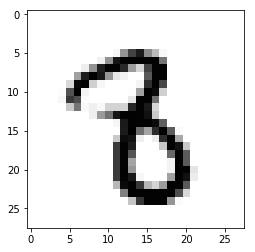



Adversarial Example: 


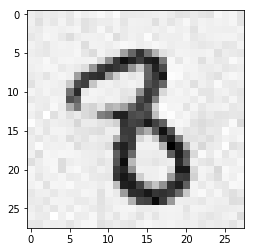

Network Prediction: 6

Network Output: 
[[0.  ]
 [0.  ]
 [0.  ]
 [0.  ]
 [0.  ]
 [0.  ]
 [0.89]
 [0.  ]
 [0.01]
 [0.  ]]



In [88]:
# sneaky_generate(target label, target digit)
adv_ex = sneaky_generate(6, 8)

So how could we protect against these adversarial attacks? One very simple way would be to use binary thresholding. Set a pixel as completely black or completely white depending on a threshold. This should remove the "noise" that's always present in the adversarial images. Let's see if it works:

In [10]:
def binary_thresholding(n, m):
    """
    n: int 0-9, the target number to match
    m: index of example image to use (from the test set)
    """
    
    x = sneaky_generate(n, m)

    x = (x > .5).astype(float)
    
    print("With binary thresholding: ")
    
    plt.imshow(x.reshape(28,28), cmap="Greys")
    plt.show()
    
    print("Prediction with binary thresholding: " + str(np.argmax(np.round(net.feedforward(x)))) + '\n')
    
    print("Network output: ")
    print(np.round(net.feedforward(x), 2))


What we want our adversarial example to look like: 


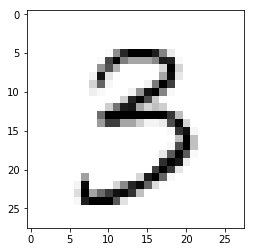



Adversarial Example: 


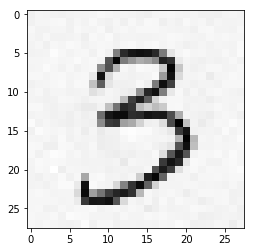

Network Prediction: 0

Network Output: 
[[ 0.98]
 [ 0.  ]
 [ 0.  ]
 [ 0.04]
 [ 0.  ]
 [ 0.  ]
 [ 0.  ]
 [ 0.  ]
 [ 0.  ]
 [ 0.  ]]

With binary thresholding: 


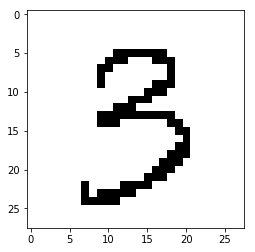

Prediction with binary thresholding: 3

Network output: 
[[ 0.]
 [ 0.]
 [ 0.]
 [ 1.]
 [ 0.]
 [ 0.]
 [ 0.]
 [ 0.]
 [ 0.]
 [ 0.]]


In [11]:
# binary_thresholding(target digit, actual digit)
binary_thresholding(0, 3)

Looks like it works pretty well! However, note that most adversarial attacks, especially on convolutional neural networks trained on massive full color image sets such as imagenet, can't be defended against by a simple binary threshold.

We could try one more thing that might be a bit more universal to protect our neural network against adversarial attacks. If we had access to the adversarial attack method (which we do in this case, because we're the ones implementing the attack) we could create a ton of adversarial examples, mix that up with our training dataset with the correct labels, and then retrain a network on this augmented dataset. The retrained network should learn to ignore the adversarial attacks. Here we implement a function to do just that

In [12]:
def augment_data(n, data, steps):
    """
    n : integer
        number of adversarial examples to generate
    data : list of tuples
        data set to generate adversarial examples using
    """
    # Our augmented training set:
    augmented = []
    
    for i in range(n):
        # Progress "bar"
        if i % 500 == 0:
            print("Generated digits: " + str(i))
            
        # Randomly choose a digit that the example will look like
        rnd_actual_digit = np.random.randint(10)
        
        # Find random instance of rnd_actual_digit in the training set
        rnd_actual_idx = np.random.randint(len(data))
        while np.argmax(data[rnd_actual_idx][1]) != rnd_actual_digit:
            rnd_actual_idx = np.random.randint(len(data))
        x_target = data[rnd_actual_idx][0]
        
        # Choose value for adversarial attack
        rnd_fake_digit = np.random.randint(10)
        
        # Generate adversarial example
        x_adversarial = sneaky_adversarial(net, rnd_fake_digit, x_target, steps, 1)
        
        # Add new data
        y_actual = data[rnd_actual_idx][1]
        
        augmented.append((x_adversarial, y_actual))
        
    return augmented

In [13]:
# This will take quite a while (~3 min for 10000, ~15 for 50000)
# Try 10000 examples first if you don't want to wait
augmented = augment_data(10000, training_data, 100)

Generated digits: 0
Generated digits: 500
Generated digits: 1000
Generated digits: 1500
Generated digits: 2000
Generated digits: 2500
Generated digits: 3000
Generated digits: 3500
Generated digits: 4000
Generated digits: 4500
Generated digits: 5000
Generated digits: 5500
Generated digits: 6000
Generated digits: 6500
Generated digits: 7000
Generated digits: 7500
Generated digits: 8000
Generated digits: 8500
Generated digits: 9000
Generated digits: 9500


Now let's check to make sure our augmented dataset actually makes sense. Here we have a function that checks the $ i^{th} $ example in our augmented set.

Image: 



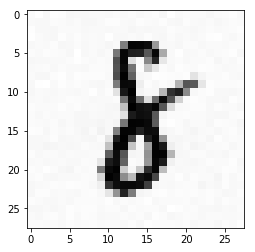

Original network prediction: 

[[ 0.  ]
 [ 0.  ]
 [ 0.01]
 [ 0.01]
 [ 0.  ]
 [ 0.  ]
 [ 0.  ]
 [ 0.  ]
 [ 0.03]
 [ 0.  ]]

Label: 

[[ 0.]
 [ 0.]
 [ 0.]
 [ 0.]
 [ 0.]
 [ 0.]
 [ 0.]
 [ 0.]
 [ 1.]
 [ 0.]]


In [14]:
def check_augmented(i, augmented):
    # Show image
    print('Image: \n')
    plt.imshow(augmented[i][0].reshape(28,28), cmap='Greys')
    plt.show()
    
    # Show original network prediction
    print('Original network prediction: \n')
    print(np.round(net.feedforward(augmented[i][0]), 2))
    
    # Show label
    print('\nLabel: \n')
    print(augmented[i][1])

# check i^th adversarial image
check_augmented(239, augmented)

We can now create a new neural network and train it on our augmented dataset and the original training set, using the original test set to validate.

In [18]:
# Create new network
net2 = Network.Network([784, 30, 10])

# Train on augmented + original training set
net2.SGD(augmented + training_data, 30, 10, 3.0, test_data=test_data)

Epoch 0: 9084 / 10000
Epoch 1: 9267 / 10000
Epoch 2: 9316 / 10000
Epoch 3: 9372 / 10000
Epoch 4: 9370 / 10000
Epoch 5: 9422 / 10000
Epoch 6: 9431 / 10000
Epoch 7: 9408 / 10000
Epoch 8: 9454 / 10000
Epoch 9: 9444 / 10000
Epoch 10: 9480 / 10000
Epoch 11: 9476 / 10000
Epoch 12: 9485 / 10000
Epoch 13: 9500 / 10000
Epoch 14: 9489 / 10000
Epoch 15: 9521 / 10000
Epoch 16: 9489 / 10000
Epoch 17: 9489 / 10000
Epoch 18: 9489 / 10000
Epoch 19: 9514 / 10000
Epoch 20: 9508 / 10000
Epoch 21: 9505 / 10000
Epoch 22: 9478 / 10000
Epoch 23: 9503 / 10000
Epoch 24: 9501 / 10000
Epoch 25: 9516 / 10000
Epoch 26: 9483 / 10000
Epoch 27: 9508 / 10000
Epoch 28: 9499 / 10000
Epoch 29: 9502 / 10000


With a network trained on 50000 adversarial examples in addition to 50000 original training set examples we get about 95% accuracy (it takes quite a long time as well). We can make a test set of adversarial examples by using the following function call:

In [19]:
# For some reason the training data has the format: list of tuples
# tuple[0] is np array of image
# tuple[1] is one hot np array of label
# test data is also list of tuples
# tuple[0] is np array of image
# tuple[1] is integer of label
# Just fixing this:
normal_test_data = []

for i in range(len(test_data)):
    ground_truth = test_data[i][1]
    one_hot = np.zeros(10)
    one_hot[ground_truth] = 1
    one_hot = np.expand_dims(one_hot, axis=1)
    normal_test_data.append((test_data[i][0], one_hot))
    

# Using normal_test_data because of weird way data is packaged
adversarial_test_set = augment_data(1000, normal_test_data, 100)

Generated digits: 0
Generated digits: 500


Let's checkout the accuracy of our newly trained network on adversarial examples from the new adversarial test set:

In [20]:
def accuracy(net, test_data):
    """
    net : network object
    test_data: list
        list of 2-tuples of two arrays, one image and one label (one-hot)
    """
    tot = float(len(test_data))
    correct = 0
    for i in range(len(test_data)):
        correct += int(np.argmax(net.feedforward(test_data[i][0])) == np.argmax(test_data[i][1]))
    
    return correct / tot

print('Accuracy: ' + str(accuracy(net2, adversarial_test_set)))

Accuracy: 0.957


We get an accuracy of about 95% on adversarial examples, which is much better than the 0% we were getting with the original network! Oddly enough, increasing the steps when generating the `adversarial_test_set` doesn't reduce the accuracy, but reducing it enough does. This is probably because at the step size we're using the adversarial example has already converged. When we use fewer steps, the adversarial examples are only partly converged (and probably don't look that great). 

And finally, a function that compares the original network to the new network on adversarial examples

Original network prediction: 0

New network prediction: 7

Image: 



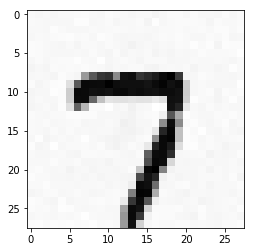

In [21]:
def sample_test(net, net2, test_data, n):
    print('Original network prediction: ' + str(np.argmax(np.round(net.feedforward(test_data[n][0])))) + '\n')
    print('New network prediction: ' + str(np.argmax(np.round(net2.feedforward(test_data[n][0])))) + '\n')
    print('Image: \n')
    plt.imshow(test_data[n][0].reshape(28,28), cmap='Greys')

sample_test(net, net2, adversarial_test_set, 238)